In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns


def set_fatty_liver_categories(stiffness):
    """
    Given liver stiffness value, assigns a string labeled Normal, Moderate, Severe, or Cirrhosis.
    :param stiffness: float of Liver stiffness in kPa.
    :return: string of bucket to value is to be categorized in.
    """
    if stiffness < 7.5:
        return "Normal"
    elif 7.5 <= stiffness < 10:
        return "Moderate"
    elif 10 <= stiffness < 14:
        return "Severe"
    elif stiffness >= 14:
        return "Cirrhosis"



def adjust_income_values(income):
    """
    Given an income code, assigns a descriptive label corresponding to NHANES codebook.
    :param income: int income code.
    :return: string descriptive label for income codes.
    """
    if income == 1:
        return "0 to 4,999"
    elif income == 2:
        return "5,000 to 9,999"
    elif income == 3:
        return "10,000 to 14,999"
    elif income == 4:
        return "15,000 to 19,999"
    elif income == 5:
        return "20,000 to 24,999"
    elif income == 6:
        return "25,000 to 34,999"
    elif income == 7:
        return "35,000 to 44,999"
    elif income == 8:
        return "45,000 to 54,999"
    elif income == 9:
        return "55,000 to 64,999"
    elif income == 10:
        return "65,000 to 74,999"
    elif income == 12:
        return "20,000 and over"
    elif income == 13:
        return income == "Under 20,000"
    elif income == 14:
        return "75,000 to 99,999"
    elif income == 15:
        return "100,000 and Over"
    elif income == 77:
        return "Refused"
    elif income == 99:
        return "Don't Know"
    elif income == ".":
        return ""


def adjust_edu_values(edu):
    """
    Assigns education level codes a descriptive label.
    :param edu: int education level code.
    :return: string descriptive label for education level code.
    """
    if edu == 1:
        return "Less than high school degree"
    elif edu == 2:
        return "High school / GED / AA degree"
    elif edu == 3:
        return "College graduate or above"
    elif edu == 7:
        return "Refused"
    elif edu == 9:
        return "Don't Know"
    elif edu == ".":
        return ""


def adjust_age_values(age):
    """
    Given age code, assigns a descriptive label.
    :param age: int age code.
    :return: string descriptive label for an age code.
    """
    if age == 1:
        return "<20 years"
    elif age == 2:
        return "20-39 years"
    elif age == 3:
        return "40-59 years"
    elif age == 4:
        return "60+ years"
    elif age == ".":
        return ""

def adjust_gender_values(gender):
    """
    Assigns string label to gender code.
    :param gender: int gender code, 1 == male, 2 == female
    :return: string label for male or female.
    """
    if gender == 1:
        return "Male"
    elif gender == 2:
        return "Female"

def adjust_cap_values(cap):
    """
    Given a CAP score for liver steatosis, assigns stage levels for severity.
    :param cap: int CAP score.
    :return: string label for liver steatosis severity.
    """
    if cap < 238:
        return "Normal"
    elif 238 <= cap <= 260:
        return "S1"
    elif 260 < cap <= 290:
        return "S2"
    elif cap > 290:
        return "S3"

def calculate_bmi(weight, height):
    """
    Calculates bmi given weight and height and assigns a category for that bmi.
    :param weight: float weight in kilograms (kg).
    :param height: float height in centimeters (cm).
    :return: string category for calculated bmi.
    """
    height = height / 100  # Convert to meters
    bmi = weight / (height ** 2)
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi <= 24.9:
        return "Normal Weight"
    elif 25 <= bmi <= 29.9:
        return "Overweight"
    elif bmi >= 30:
        return "Obese"

c:\users\ted\appdata\local\programs\python\python39\lib\site-packages\pandas\core\reshape\merge.py:1207: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  warnings.warn(


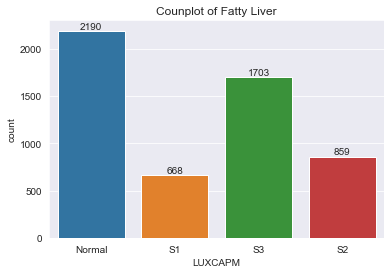

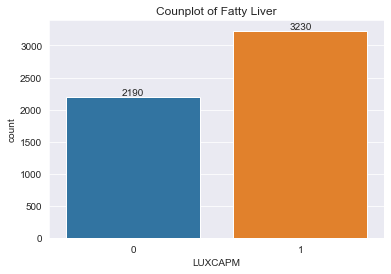

              precision    recall  f1-score   support

           0       0.56      0.06      0.11       669
           1       0.60      0.97      0.74       957

    accuracy                           0.59      1626
   macro avg       0.58      0.51      0.42      1626
weighted avg       0.58      0.59      0.48      1626



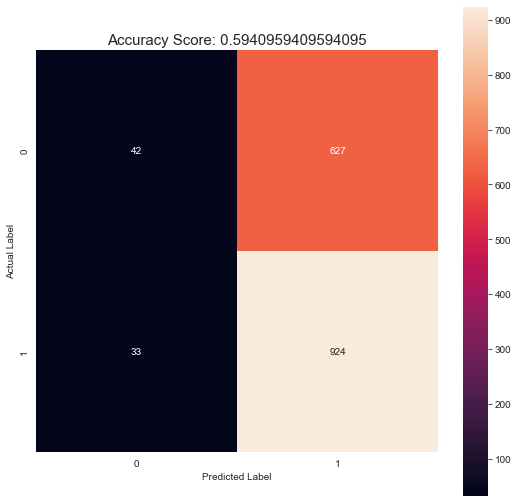

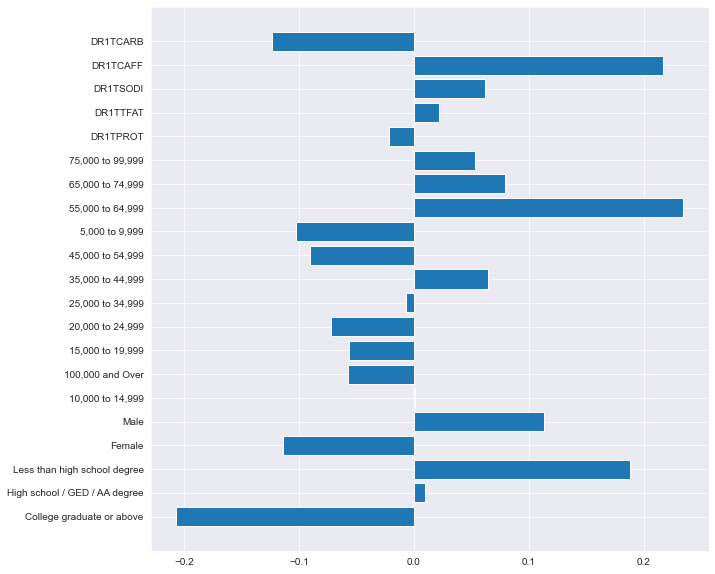

In [35]:
%matplotlib inline

# Import necessary files.
demographics = pd.read_csv('Z:/School/BIO-340/Project 1/DEMO_J.csv', encoding='latin1')
liver_csv = pd.read_csv('Z:/School/BIO-340/Project 1/LUX_J.csv', encoding='latin1')
dietary_csv = pd.read_csv('Z:/School/BIO-340/Project 1/DR1TOT_J.csv', encoding='latin1')
body_csv = pd.read_csv('Z:/School/BIO-340/Project 1/BMX_J.csv', encoding='latin1')

# Select columns of interest - see data_variables_to_use.txt for descritpions.
demo_x = pd.DataFrame(demographics[['SEQN', 'DMDHRAGZ', 'DMDHREDZ', 'INDHHIN2', 'RIAGENDR']])
diet_x = pd.DataFrame(dietary_csv[[
    'SEQN', 'DR1TPROT', 'DR1TTFAT', 'DR1TSODI', 'DR1TCAFF', 'DR1TCARB'
]])
body_x = pd.DataFrame(body_csv[['SEQN', 'BMXWT', 'BMXHT']])

# Select desired outcomes - ultimately use LUXCAPM.
liver_y = pd.DataFrame(liver_csv[['SEQN', 'LUXSMED', 'LUXCAPM']])

# Merge the various csvs on SEQN
data_df = demo_x.merge(liver_y, on='SEQN', how='inner')
data_df = data_df.merge(diet_x, on='SEQN', how='inner')
data_df = data_df.merge(body_x, on='SEQN', how='inner')
data_df.dropna(axis=0, inplace=True)

# Standardize continuous variables
scalar = StandardScaler()
data_df['DR1TPROT'] = scalar.fit_transform(data_df[['DR1TPROT']])
data_df['DR1TTFAT'] = scalar.fit_transform(data_df[['DR1TTFAT']])
data_df['DR1TSODI'] = scalar.fit_transform(data_df[['DR1TSODI']])
data_df['DR1TCAFF'] = scalar.fit_transform(data_df[['DR1TCAFF']])
data_df['DR1TCARB'] = scalar.fit_transform(data_df[['DR1TCARB']])

# Create dummy variables for variables.
## age = pd.get_dummies(data_df['DMDHRAGZ'].apply(adjust_age_values))
education = pd.get_dummies(data_df['DMDHREDZ'].apply(adjust_edu_values))
annual_income = pd.get_dummies(data_df['INDHHIN2'].apply(adjust_income_values), drop_first=True)
gender = pd.get_dummies(data_df['RIAGENDR'].apply(adjust_gender_values))
bmi = pd.get_dummies(data_df.apply(lambda x: calculate_bmi(x['BMXWT'], x['BMXHT']), axis=1))


liver_damage = pd.get_dummies(data_df['LUXSMED'].apply(set_fatty_liver_categories))
fatty_liver = data_df['LUXCAPM'].apply(adjust_cap_values)

# df to input into logistic regression
final_df = pd.concat([education, gender, annual_income, fatty_liver, data_df['DR1TPROT'], data_df['DR1TTFAT'], data_df['DR1TSODI'], data_df['DR1TCAFF'], data_df['DR1TCARB']], axis=1)

# Plot distribution of fatty liver stages.
ax = sns.countplot(x='LUXCAPM', data=final_df)
ax.bar_label(ax.containers[0])
ax.set_title('Counplot of Fatty Liver')
plt.show()

# Create outcome labels.
labels = pd.DataFrame(final_df['LUXCAPM'])
labels.LUXCAPM[labels.LUXCAPM == 'Normal'] = 0
labels.LUXCAPM[labels.LUXCAPM == 'S1'] = 1
labels.LUXCAPM[labels.LUXCAPM == 'S2'] = 1
labels.LUXCAPM[labels.LUXCAPM == 'S3'] = 1

# Plot distribution of label categories
ax = sns.countplot(x='LUXCAPM', data=labels)
ax.bar_label(ax.containers[0])
ax.set_title('Counplot of Fatty Liver')
plt.show()


# Drop non-useful columns and the outcome column
final_df.drop(['LUXCAPM' ,'Refused', 'Don\'t Know', '20,000 and over', '0 to 4,999'], axis=1, inplace=True)
final_df = final_df.apply(pd.to_numeric)
labels = labels.apply(pd.to_numeric)

# Logistic Regression
x_train, x_test, y_train, y_test = train_test_split(
    final_df, labels, test_size=0.3, random_state=0
)
logmodel = LogisticRegression()
logmodel.fit(x_train, np.ravel(y_train))
predict_log = logmodel.predict(x_test)

# Model evaluation starts here:
print(classification_report(y_test, predict_log))
score = logmodel.score(x_test, y_test)

# Confusion matrix
cm = confusion_matrix(y_test, predict_log)
plt.figure(figsize=(9,9))
sns.heatmap(cm, fmt='g', annot=True, square=True)
plt.ylabel('Actual Label')
plt.xlabel("Predicted Label")
plt.title(f'Accuracy Score: {score}', size=15)
plt.show()

# Variable importance
importance = logmodel.coef_.flatten()
plt.figure(figsize=(10,10))
plt.barh(final_df.columns, importance)
plt.show()